In [10]:
import networkx as nx
from dwave.cloud import Client
from dwave.system import EmbeddingComposite, DWaveSampler
import dwave.inspector
import dwave_networkx as dnx # contains the topologies of the dwave's quantum computers
import matplotlib.pyplot as plt

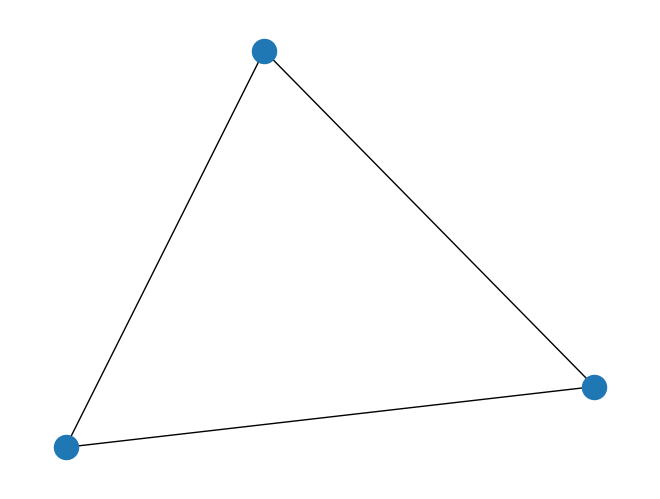

In [1]:

G1 = nx.Graph()
G1.add_node(1)
G1.add_node(2)
G1.add_node(3)
G1.add_edge(1,2)
G1.add_edge(2,3)
G1.add_edge(3,1)

nx.draw(G1)

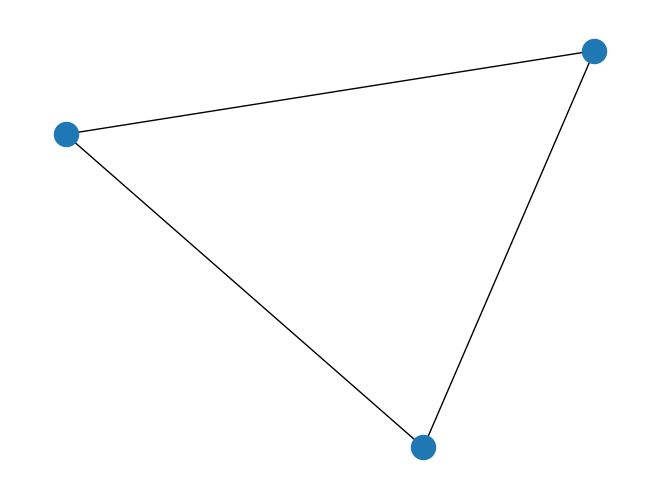

In [2]:
G2 = nx.Graph()
G2.add_edges_from([(1,2), (2,3), (3,1)])
nx.draw(G2)

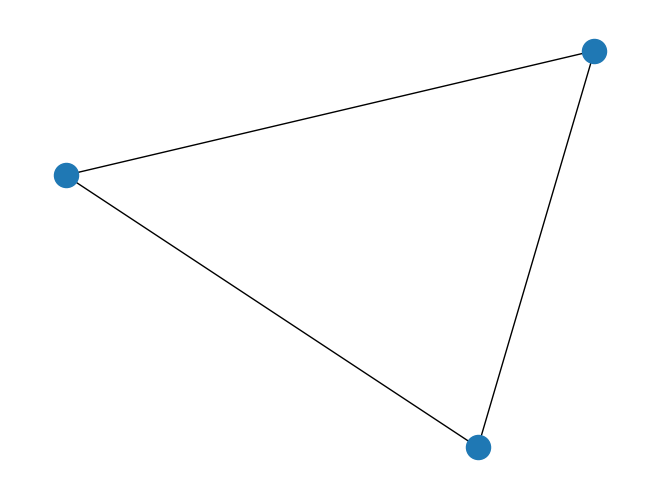

In [3]:
G3 = nx.complete_graph(3)
nx.draw(G3)

{(0, 1): Text(0.5000000000000003, 0.04786555399941256, 'first edge'),
 (0, 2): Text(-0.29107183575982487, 0.4091128461876363, 'third edge'),
 (1, 2): Text(-0.2089281642401748, -0.4569784001870481, 'second edge')}

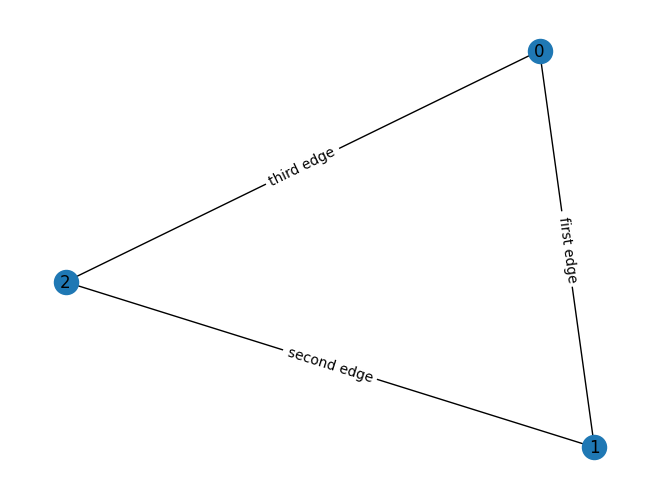

In [4]:
G4 = nx.Graph()
G4.add_edges_from([
    (0,1, {'edge attribute': 'first edge'}),
    (1,2, {'edge attribute': 'second edge'}),
    (2,0, {'edge attribute': 'third edge'}),
])

pos = nx.spring_layout(G4, seed=0) #there are many layouts
labels = nx.get_edge_attributes(G4, 'edge attribute')

nx.draw(G4, pos, with_labels=True)
nx.draw_networkx_edge_labels(G4, pos, edge_labels=labels)

In [ ]:
# DEV-c656c45b76fe02df536f0ce348eb602bcab9f1de

In [5]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !pip install dwave-ocean-sdk && dwave config create

In [6]:
with Client.from_config() as client:
  available_solvers = client.get_solvers()

for solver in available_solvers:
  print(solver)

BQMSolver(id='hybrid_binary_quadratic_model_version2')
DQMSolver(id='hybrid_discrete_quadratic_model_version1')
StructuredSolver(id='Advantage_system4.1')
CQMSolver(id='hybrid_constrained_quadratic_model_version1')
StructuredSolver(id='Advantage_system6.4')
StructuredSolver(id='Advantage2_prototype2.3')


In [8]:
with Client.from_config() as client:
  solver = client.get_solver('Advantage_system6.4')   # SELECT THE SOLVER

##### **Exercise 1**
Write the Ising model associated with the following social network:

Friendly relationships:
-	Alice & Carl
-	Alice & David
- Bob & Carl

Hostile relationships:
-	Alice & Bob
-	Bob & David


In [9]:
# Alice = 0
# Bob = 1
# Carl = 2
# Dadiv = 3

h = {} 
j = {
    (0, 2): 1,
    (0, 3): 1,
    (1, 2): 1,
    (0, 1): -1,
    (1, 3): -1
}

In [11]:
sampler = EmbeddingComposite(DWaveSampler(solver=solver.id))
N_reads = 100

response = sampler.sample_ising(h, j)

dwave.inspector.show((h, j), response) # helps visualizing the embedding

Serving Inspector on http://127.0.0.1:18000/?problemId=f1c0be46-153f-4046-aaea-38e28c047314

'http://127.0.0.1:18000/?problemId=f1c0be46-153f-4046-aaea-38e28c047314'

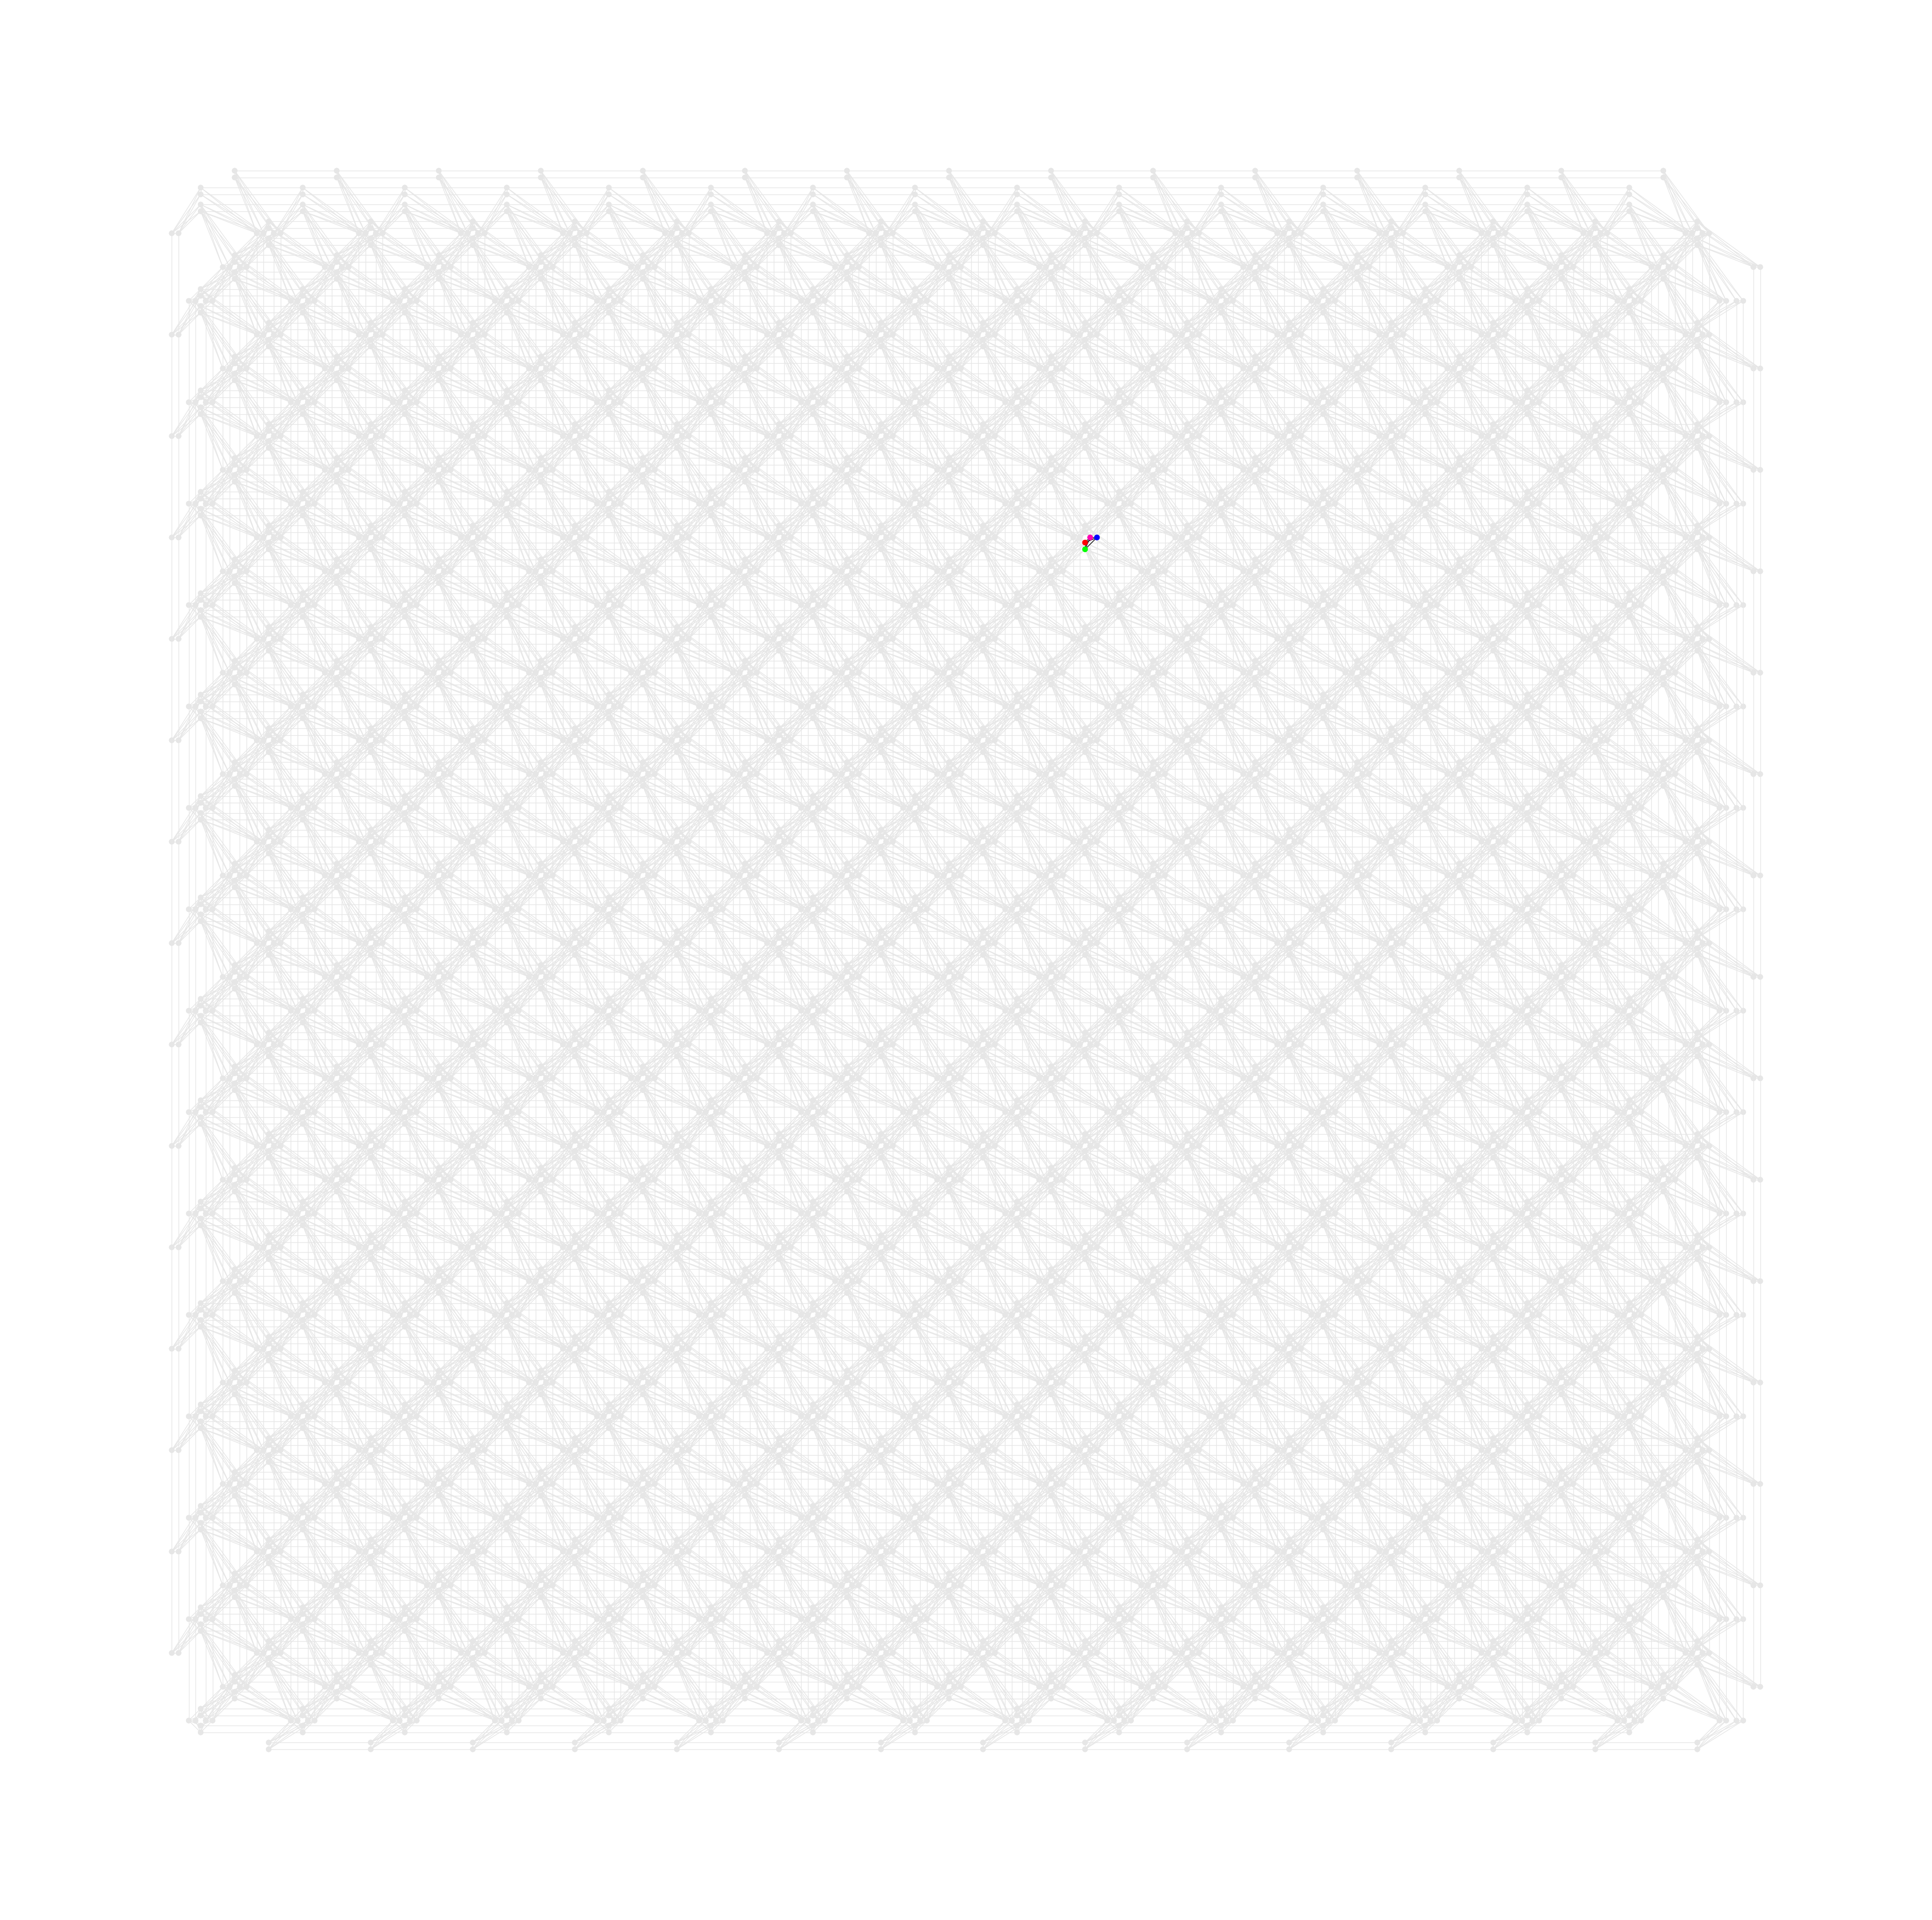

In [12]:
embedding = response.info['embedding_context']['embedding']
f, axes = plt.subplots(1, 1, figsize=(50,50))
X = dnx.pegasus_graph(16)
dnx.draw_pegasus_embedding(X, embedding, crosses=True, node_size=50, ax=axes)

In [13]:
for samp in response.data(['sample']):
  print(samp.sample)

{0: -1, 1: -1, 2: 1, 3: -1}


In [14]:
import numpy as np
for conf, en, num in response.data(['sample','energy','num_occurrences']):
  print([conf[x] for x in conf])
  print('Energy=', en, '\tprob_res=',num*100/N_reads,'%\n')

[-1, -1, 1, -1]
Energy= -3.0 	prob_res= 1.0 %


# Exercise 3

In [15]:
response.data(['sample']).first

AttributeError: 'generator' object has no attribute 'first'

# Exercise 4

{(0, 2): Text(0.48097817573407015, -0.3076550349572388, '1'),
 (0, 3): Text(-0.5038412517108535, -0.10959853881846751, '1'),
 (0, 1): Text(0.015180572555076552, 0.07472226358613623, '-1'),
 (2, 1): Text(0.5038412517108536, 0.1095985388184674, '1'),
 (3, 1): Text(-0.48097817573407, 0.30765503495723867, '-1')}

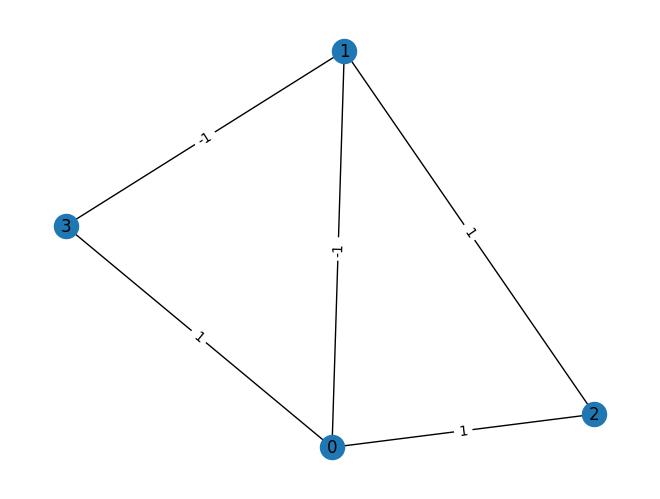

In [17]:
social = nx.Graph()
social.add_edges_from([
    (0, 2, {'sign': 1}),
    (0, 3, {'sign': 1}),
    (1, 2, {'sign': 1}),
    (0, 1, {'sign': -1}),
    (1, 3, {'sign': -1}),
])

pos = nx.spring_layout(social, seed=0)  #there are many layouts
labels = nx.get_edge_attributes(social, 'sign')

nx.draw(social, pos, with_labels=True)
nx.draw_networkx_edge_labels(social, pos, edge_labels=labels)

In [18]:
h = {v: 0 for v in social}

J = {}
for v1, v2, data in social.edges(data=True):
  J[(v1,v2)] = -1 * data['sign']

In [19]:
sampler = EmbeddingComposite(DWaveSampler('Advantage_system6.4'))
response = sampler.sample_ising(h,J)

In [20]:
response.to_pandas_dataframe()

0  1  2  3  chain_break_fraction  energy  num_occurrences
0 -1  1 -1 -1                   0.0    -3.0                1

# Exercise 5

In [27]:
import random

names = ["Anna", "Mitch", "Luke", "Dieg", "Erne Pedro", "Cla", "Ste", "Bussa", "EVA AMORE MIO", "Bajoni"]

# make the network

G = nx.complete_graph(10)
G.add_edges_from([(u, v, {'sign': 2*random.randint(0, 1) -1}) for u,v in G.edges])
nx.relabel_nodes(G, {vertex: name for vertex, name in enumerate(names)}, copy = False)

print("Friendly relationship: \n\t" + "\n\t".join(list (x + " & " + y for (x, y, sign) in G.edges(data = 'sign') if (sign == 1))))
print("Hostile relationship: \n\t" + "\n\t".join(list (x + " & " + y for (x, y, sign) in G.edges(data = 'sign') if (sign == -1))))

Friendly relationship: 
	Anna & Luke
	Anna & Erne Pedro
	Anna & Bussa
	Anna & EVA AMORE MIO
	Mitch & Luke
	Mitch & Dieg
	Mitch & Erne Pedro
	Mitch & Cla
	Mitch & Ste
	Mitch & EVA AMORE MIO
	Mitch & Bajoni
	Luke & Dieg
	Luke & Erne Pedro
	Luke & Cla
	Luke & Ste
	Luke & Bussa
	Luke & EVA AMORE MIO
	Luke & Bajoni
	Dieg & Erne Pedro
	Dieg & Bussa
	Erne Pedro & Bussa
	Erne Pedro & EVA AMORE MIO
	Cla & Bussa
	Ste & Bussa
	Bussa & EVA AMORE MIO
	Bussa & Bajoni
Hostile relationship: 
	Anna & Mitch
	Anna & Dieg
	Anna & Cla
	Anna & Ste
	Anna & Bajoni
	Mitch & Bussa
	Dieg & Cla
	Dieg & Ste
	Dieg & EVA AMORE MIO
	Dieg & Bajoni
	Erne Pedro & Cla
	Erne Pedro & Ste
	Erne Pedro & Bajoni
	Cla & Ste
	Cla & EVA AMORE MIO
	Cla & Bajoni
	Ste & EVA AMORE MIO
	Ste & Bajoni
	EVA AMORE MIO & Bajoni


{('Anna', 'Mitch'): Text(0.052334567600921755, -0.560519656213298, '1'),
 ('Anna', 'Luke'): Text(-0.652518826666634, -0.30683717737769867, '1'),
 ('Anna', 'Dieg'): Text(-0.34629202078961446, 0.3088005798130225, '-1'),
 ('Anna',
  'Erne Pedro'): Text(-0.020057073422169114, -0.03447561330471387, '-1'),
 ('Anna', 'Cla'): Text(0.3096367058734549, -0.32411497811305745, '1'),
 ('Anna', 'Ste'): Text(0.015030038772971765, 0.3483551617400783, '1'),
 ('Anna', 'Bussa'): Text(-0.3143131546763152, -0.6320994095277139, '1'),
 ('Anna', 'Prati'): Text(-0.5915483808546163, 0.07265555638938181, '-1'),
 ('Anna', 'Bajoni'): Text(0.31655577129866064, 0.07144026037228826, '-1'),
 ('Mitch', 'Luke'): Text(-0.29239116584987734, -0.6031580145355688, '1'),
 ('Mitch', 'Dieg'): Text(0.013835640027142215, 0.012479742655152337, '1'),
 ('Mitch', 'Erne Pedro'): Text(0.34007058739458756, -0.33079645046258405, '1'),
 ('Mitch', 'Cla'): Text(0.6697643666902116, -0.6204358152709276, '-1'),
 ('Mitch', 'Ste'): Text(0.3751576

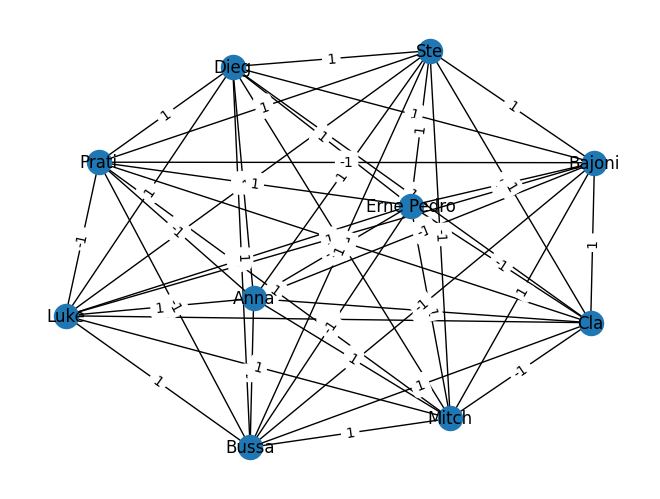

In [22]:

pos = nx.spring_layout(G, seed=0)  #there are many layouts
labels = nx.get_edge_attributes(G, 'sign')

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [26]:
sampler = EmbeddingComposite(DWaveSampler('Advantage_system6.4'))
response = sampler.sample_ising(h,J)
sample = next(iter(response))

colors = {v: (spin+1)//2 for v, spin in sample.items()}

frustrated_edges = {}

for u, v, data in G.edges(data=True):
    sign = data['sign']

    if sign > 0 and colors[u] != colors[v]:
        frustrated_edges[(u, v)] = data
    elif sign < 0 and colors[u] == colors[v]:
        frustrated_edges[(u, v)] = data

KeyError: 'Anna'

In [25]:
# Mark on the graph the returned frustrated edges and node set (color)
for edge in G.edges:
    G.edges[edge]['frustrated'] = edge in frustrated_edges
for node in G.nodes:
    G.nodes[node]['color'] = colors[node]

print('Yellow set: \n\t' + '\n\t'.join(list(person for (person, color) in colors.items() if (color == 0))))
print('Blue set: \n\t' + '\n\t'.join(list(person for (person, color) in colors.items() if (color == 1))))
print('Frustrated relationships: \n\t' + '\n\t'.join(list(x + " & " + y for (x, y) in frustrated_edges.keys())))

NameError: name 'frustrated_edges' is not defined

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product

edgelist = G.edges()
nodelist = G.nodes()

position = nx.circular_layout(G) # try more fancy layouts

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_facecolor('#202239')
circle_size = 200

edge_color = ['#87DACD' if G[v1][v2]['sign'] == 1 else '#FC9291' for v1,v2 in edgelist]
node_color = ['#4378F8' if nodelist[v]['color'] else '#FFE897' for v in nodelist]
edge_style = ['dashed' if G[u][v]['frustrated'] else 'solid' for u,v in edgelist]

nx.draw_networkx_nodes(G, pos = position, node_color=node_color, node_size=circle_size)
edge_collect = nx.draw_networkx_edges(G, pos = position, edgelist=edgelist, edge_color=edge_color, style=edge_style)

nx.draw_networkx_labels(G, pos=position, font_size=20, font_color='white', horizontalalignment='right', verticalalignment='top')

plt.show()

In [ ]:
edgelist = G.edges()
nodelist = G.nodes()

dist = defaultdict(dict)
for u,v in product(nodelist, repeat=2):
  if u == v:
    dist[u][v] = 0
  elif nodelist[u]['color'] == nodelist[v]['color']:
    dist[u][v] = 1
  else:
    dist[u][v] = 2
position = nx.kamada_kawai_layout(G, dist)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_facecolor('#202239')
circle_size = 200

edge_color = ['#87DACD' if G[v1][v2]['sign'] == 1 else '#FC9291' for v1,v2 in edgelist]
node_color = ['#4378F8' if nodelist[v]['color'] else '#FFE897' for v in nodelist]
edge_style = ['dashed' if G[u][v]['frustrated'] else 'solid' for u,v in edgelist]

nx.draw_networkx_nodes(G, pos = position, node_color=node_color, node_size=circle_size)
edge_collect = nx.draw_networkx_edges(G, pos = position, edgelist=edgelist, edge_color=edge_color, style=edge_style)

nx.draw_networkx_labels(G, pos=position, font_size=20, font_color='white', horizontalalignment='right', verticalalignment='top')

plt.show()